# Deep Learning–Based Ship Detection using SAR Imagery : YOLOv8 Model
YOLO stands for “You Only Look Once”. It is one of the most popular object detection models in computer vision. 

Datasets: SARscope: Synthetic Aperture Radar Maritime Images
Source: https://www.kaggle.com/datasets/kailaspsudheer/sarscope-unveiling-the-maritime-landscape

#### Install Packages

In [ ]:
'''
Ultralytics is a package that provides ready to use YOLO models.
Source: https://docs.ultralytics.com/quickstart/
'''
!pip install ultralytics # Install the ultralytics package



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 18.1 MB/s eta 0:00:00a 0:00:01


#### Import packages

In [ ]:
import numpy as np
import random
import os
import json
import shutil
import pandas as pd
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt
from collections import defaultdict


### Utility Functions

This section contains reusable helper functions that can be reused.

In [ ]:
def plot_curve(results):
    '''
    Plots training and validation curves for box loss, class loss, and mAP metrics.
    Input:
        results: pandas DataFrame containing training results
    '''
    fig, axes = plt.subplots(1, 3, figsize=(12, 6))
    
    # 1. GIoU Loss (main localization loss for RT-DETR)
    axes[0].plot(results['epoch'], results['train/box_loss'], label='Train Box Loss', marker='o')
    axes[0].plot(results['epoch'], results['val/box_loss'], label='Val Box Loss', marker='o')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Box Loss')
    axes[0].set_title('Box Loss: Train vs Validation')
    axes[0].legend()
    axes[0].grid(True)
    
    # 2. Class Loss
    axes[1].plot(results['epoch'], results['train/cls_loss'], label='Train Class Loss', marker='o')
    axes[1].plot(results['epoch'], results['val/cls_loss'], label='Val Class Loss', marker='o')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Class Loss')
    axes[1].set_title('Class Loss: Train vs Validation')
    axes[1].legend()
    axes[1].grid(True)
    
    # 3. mAP Metrics
    axes[2].plot(results['epoch'], results['metrics/mAP50(B)'], label='mAP50', marker='o', linewidth=2)
    axes[2].plot(results['epoch'], results['metrics/mAP50-95(B)'], label='mAP50-95', marker='o', linewidth=2)
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('mAP')
    axes[2].set_title('Validation mAP Over Time')
    axes[2].legend()
    axes[2].grid(True)

    plt.tight_layout()
    plt.savefig('/kaggle/working/training_curves.png', dpi=150)
    plt.show()


def plot_pred_results(pred_results,num_images,images_per_row):
    '''
    Plots predicted results from YOLO model inference.
    Input:
        pred_results: list of prediction results from YOLO model
        num_images: number of images to plot
        images_per_row: number of images per row in the plot
    '''
    # Calculate number of rows needed
    rows = (num_images + images_per_row - 1) // images_per_row
    
    plt.figure(figsize=(images_per_row * 5, rows * 5))
    
    for i in range(num_images):
        pred_img = pred_results[i].plot()  # image with boxes drawn
        
        plt.subplot(rows, images_per_row, i + 1)
        plt.imshow(pred_img)
        plt.axis('off')
        plt.title(f"Image {i+1}")
    
    plt.tight_layout()
    plt.show()

def show_yolo_image(image_path, label_path):
    """
    Displays an image with YOLO format bounding boxes drawn on it.
    Input:
        image_path: path to the image file
        label_path: path to the YOLO annotation file
    """
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape

    # Read YOLO annotations
    with open(label_path) as f:
        for line in f.readlines():
            parts = line.strip().split()
            class_id, x_center, y_center, bw, bh = map(float, parts)

            # Convert from normalized to pixel coordinates
            x_center *= w  # pixel x-coordinate of box center
            y_center *= h  # pixel y-coordinate of box center
            bw *= w        # box width in pixels
            bh *= h        # box height in pixels

            x1 = int(x_center - bw/2) #left
            y1 = int(y_center - bh/2) #top
            x2 = int(x_center + bw/2) #right
            y2 = int(y_center + bh/2) #bottom

            # Draw rectangle
            color = (255, 0, 0)
            cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

    return img

#### Convert annotations from the COCO–MMDetection to YOLO format
The dataset is provided in **COCO–MMDetection** format which is a single large `.json` file, however the YOLO models requires labels in individual `.txt` files for each image training.   




In [ ]:
dataset_root = "/kaggle/input/sarscope-unveiling-the-maritime-landscape/SARscope"
output_root = "/kaggle/working/dataset/yolo"
splits = ["train", "valid", "test"]

if os.path.exists(output_root):
    shutil.rmtree(output_root)

for split in splits:
    print(f"Processing {split}")

    json_path = os.path.join(dataset_root, split, "_annotations.coco.json")
    images_dir = os.path.join(dataset_root, split)  

    out_img_dir = os.path.join(output_root, "images", split)
    out_lbl_dir = os.path.join(output_root, "labels", split)

    os.makedirs(out_img_dir, exist_ok=True)
    os.makedirs(out_lbl_dir, exist_ok=True)

    with open(json_path) as f:
        coco = json.load(f)

    imgs = {i["id"]: i for i in coco["images"]}
    cats = sorted(coco["categories"], key=lambda x: x["id"])
    cat_map = {c["id"]: i for i, c in enumerate(cats)}

    anns = defaultdict(list)
    for a in coco["annotations"]:
        anns[a["image_id"]].append(a)

    for img_id, img in imgs.items():
        w, h = img["width"], img["height"]
        fname = os.path.basename(img["file_name"])
        name = os.path.splitext(fname)[0]

        # write YOLO-format annotations for the image
        with open(os.path.join(out_lbl_dir, name + ".txt"), "w") as f:
            for a in anns.get(img_id, []):
                # Get bounding box coordinates (x, y, width, height)
                x, y, bw, bh = a["bbox"]
                # Convert bounding box from COCO format (top-left, width, height)
                # to YOLO format (x_center, y_center, width, height) normalized by image size
                xc = (x + bw / 2) / w
                yc = (y + bh / 2) / h
                bw /= w
                bh /= h
                f.write(f"{cat_map[a['category_id']]} {xc} {yc} {bw} {bh}\n")

        # copy image
        shutil.copy(
            os.path.join(images_dir, fname),
            os.path.join(out_img_dir, fname)
        )

# dataset.yaml
yaml = [
    f"path: {output_root}",
    "train: images/train",
    "val: images/valid",
    "test: images/test",
    f"nc: {len(cats)}",
    "names:"
]
for i, c in enumerate(cats):
    yaml.append(f"  {i}: {c['name']}")

with open(os.path.join(output_root, "dataset.yaml"), "w") as f:
    f.write("\n".join(yaml))

Processing train
Processing valid
Processing test


#### Plot input image with annotation

In [8]:
train_img_dir = "/kaggle/working/dataset/yolo/images/train"
train_lbl_dir = "/kaggle/working/dataset/yolo/labels/train"
no_of_images=6
sample_images = random.sample(os.listdir(train_img_dir), no_of_images)

# Plot them in the same row
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, img_file in zip(axes, sample_images):
    image_path = os.path.join(train_img_dir, img_file)
    label_file = img_file.replace(".jpg", ".txt")
    label_path = os.path.join(train_lbl_dir, label_file)
    
    img = show_yolo_image(image_path, label_path)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(img_file, fontsize=10)

plt.tight_layout()
plt.show()



### 1. YOLOv8 Medium Model

#### 1.1 Model Training 

In [ ]:
# Load a COCO-pretrained YOLOv8n model
model_v8m = YOLO("yolov8m.pt")

# Display model information (optional)
model_v8m.info()


YOLOv8m summary: 169 layers, 25,902,640 parameters, 0 gradients, 79.3 GFLOPs


(169, 25902640, 0, 79.3204224)

In [ ]:
# Train the medium YOLOv8 model with epochs=20, batch=16, image size=640
v8m_train_results= model_v8m.train(data="/kaggle/working/dataset/yolo/dataset.yaml", epochs=20, batch=16, imgsz=640)


Ultralytics 8.3.252 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/dataset/yolo/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ef1f45cd430>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [ ]:
# Load training results
model_v8m_results_path = '/kaggle/working/runs/detect/train/results.csv'
model_v8m_results = pd.read_csv(model_v8m_results_path)
model_v8m_results.columns = model_v8m_results.columns.str.strip()

print("Available columns:")
print(model_v8m_results.columns.tolist())
print("\nFirst few rows:")
print(model_v8m_results.head())

Available columns:
['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']

First few rows:
   epoch     time  train/box_loss  train/cls_loss  train/dfl_loss  \
0      1  173.686         1.46132         1.20305         1.10526   
1      2  349.024         1.47847         1.02982         1.15145   
2      3  523.382         1.45840         0.99228         1.13139   
3      4  696.883         1.39067         0.92501         1.09269   
4      5  870.145         1.32308         0.87658         1.06683   

   metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
0               0.64888            0.35890           0.39198   
1               0.78107            0.60672           0.70776   
2               0.81344            0.66306           0.75526   
3               0.84045            0.65062           0.

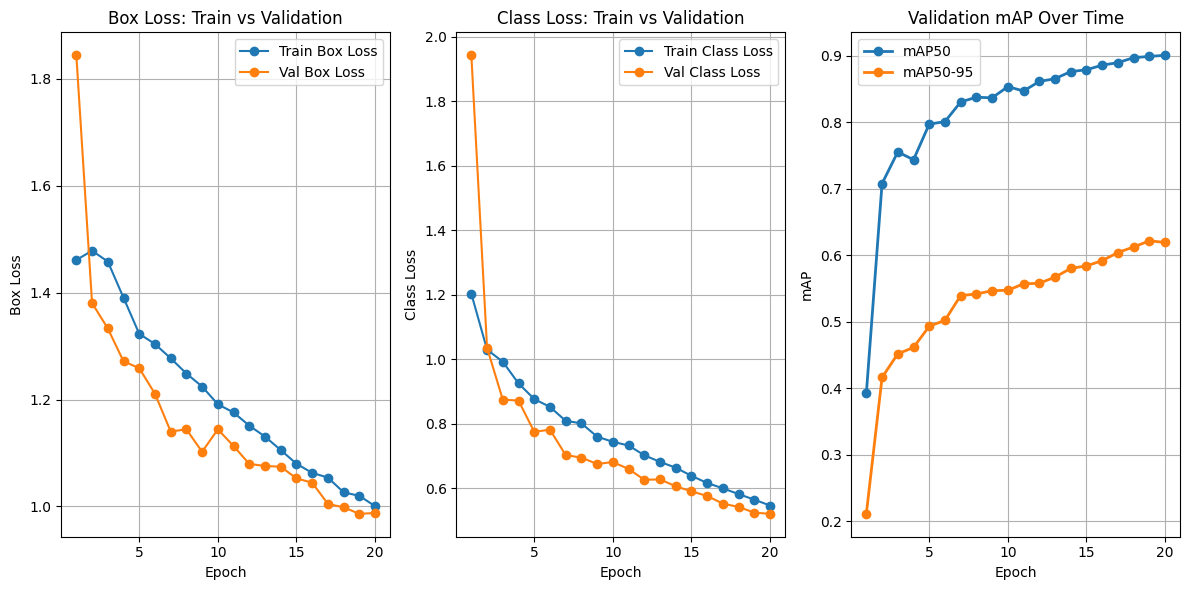

In [ ]:
# Plot training curves
plot_curve(model_v8m_results)

##### Analysis:

**Box Loss and Class Loss (Train vs Validation)**

- Both train and validation box losses decrease steadily and smoothly throughout training

- Validation loss is consistently lower than training loss


**Validation mAP curves**

- mAP50 improves very quickly in first 5–7 epochs, then continues steady (but slower) improvement

- mAP50-95 follows almost the same trend but with lower absolute values (as expected)

#### 1.2 Testing
Model evaluation on test datasets

In [ ]:
# Load the best YOLOv8m model after training 
best_yolov8m_model_path="/kaggle/working/runs/detect/train/weights/best.pt"
yolov8m_model = YOLO(best_yolov8m_model_path)

In [17]:
# Evaluate on test set explicitly
_ = yolov8m_model.val(data="/kaggle/working/dataset/yolo/dataset.yaml", 
                                 split="test")  # split="test" tells it to use test images



Ultralytics 8.3.252 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1175.0±439.1 MB/s, size: 57.4 KB)
val: Scanning /kaggle/working/dataset/yolo/labels/test... 672 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 672/672 1.5Kit/s 0.5s0.1ss
val: New cache created: /kaggle/working/dataset/yolo/labels/test.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 42/42 2.2it/s 19.3s0.5s
                   all        672       2014      0.902      0.803      0.884      0.605
Speed: 1.1ms preprocess, 24.3ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to /kaggle/working/runs/detect/val


#### 1.3 Prediction

In [18]:
# Predict on all test images
v8m_pred_results = yolov8m_model.predict("/kaggle/working/dataset/yolo/images/test/*", conf=0.5)


image 1/672 /kaggle/working/dataset/yolo/images/test/000003_jpg.rf.d35f1b3e7a2f971d5edb6bd95bdb0af4.jpg: 640x640 1 ship, 36.9ms
image 2/672 /kaggle/working/dataset/yolo/images/test/000047_jpg.rf.a7c5a75819459815e026bd5f7c0c5d3d.jpg: 640x640 2 ships, 36.9ms
image 3/672 /kaggle/working/dataset/yolo/images/test/000059_jpg.rf.e7369a146592d0d45241a640ac951d5c.jpg: 640x640 5 ships, 36.9ms
image 4/672 /kaggle/working/dataset/yolo/images/test/000062_jpg.rf.74c3c4bcb7a59fb971a4bbe573235055.jpg: 640x640 1 ship, 36.8ms
image 5/672 /kaggle/working/dataset/yolo/images/test/000069_jpg.rf.34afecb18bccfc3ce078330ec0d18094.jpg: 640x640 1 ship, 31.7ms
image 6/672 /kaggle/working/dataset/yolo/images/test/000086_jpg.rf.bbc50f90494434e8ea43df96263ff54a.jpg: 640x640 1 ship, 24.8ms
image 7/672 /kaggle/working/dataset/yolo/images/test/000096_jpg.rf.2ceab787373bba737023b8fced5b2cb0.jpg: 640x640 1 ship, 24.8ms
image 8/672 /kaggle/working/dataset/yolo/images/test/000097_jpg.rf.7ee59769af8798229e3743973e1f6c53.j

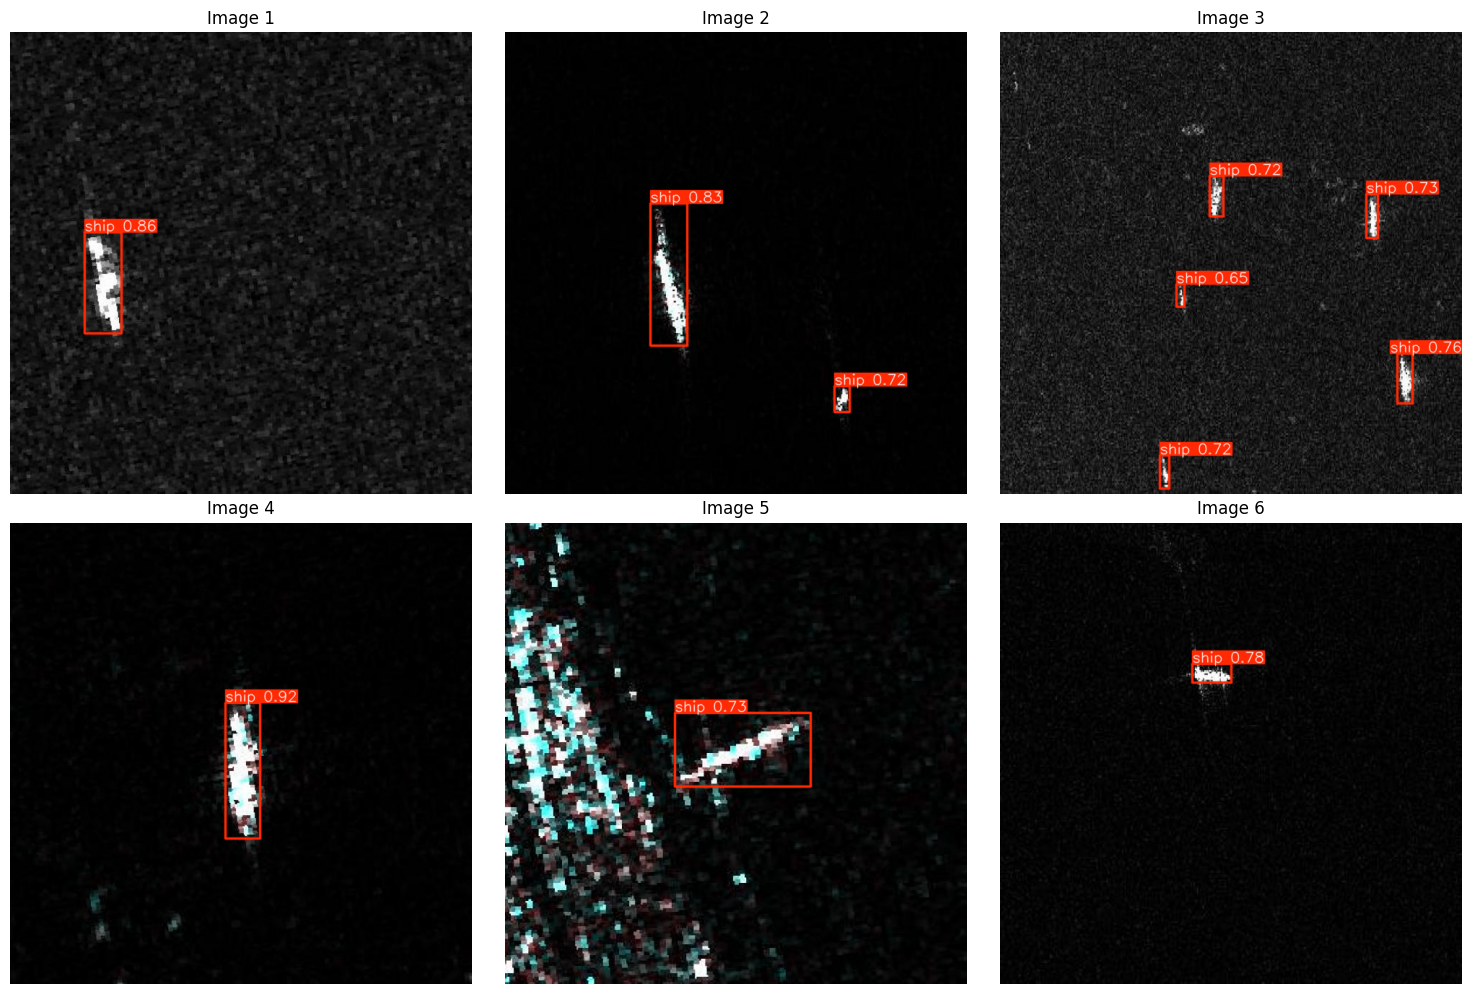

In [ ]:
# Plot prediction results
plot_pred_results(v8m_pred_results,6,3)

In [ ]:
# Zip the runs directory for download
shutil.make_archive("/kaggle/working/runs_v3", 'zip', "/kaggle/working/runs")

'/kaggle/working/runs_v3.zip'

### 2. YOLOv8 Large Model

#### 2.1 Training


In [ ]:
# Load a COCO-pretrained YOLOv8n model
model_v8l = YOLO("yolov8l.pt")

# Display model information (optional)
model_v8l.info()

YOLOv8l summary: 209 layers, 43,691,520 parameters, 0 gradients, 165.7 GFLOPs


(209, 43691520, 0, 165.742848)

In [24]:
# Train the model on the COCO8 example dataset for 100 epochs
model_v8l_train = model_v8l.train(data="/kaggle/working/dataset/yolo/dataset.yaml", epochs=20, batch=16, imgsz=640)

New https://pypi.org/project/ultralytics/8.3.253 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.252 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/dataset/yolo/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=Fal

In [ ]:
# Load training results
model_v8l_results_path = '/kaggle/working/runs/detect/train2/results.csv'
model_v8l_results = pd.read_csv(model_v8l_results_path)
model_v8l_results.columns = model_v8l_results.columns.str.strip()

print("\nFirst few rows:")
print(model_v8l_results.head())


First few rows:
   epoch      time  train/box_loss  train/cls_loss  train/dfl_loss  \
0      1   270.714         1.50651         1.27005         1.15684   
1      2   536.052         1.53932         1.07363         1.21126   
2      3   798.693         1.49824         1.00806         1.17660   
3      4  1061.310         1.42572         0.93929         1.14094   
4      5  1323.230         1.34582         0.87911         1.11068   

   metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
0               0.31865            0.11985           0.09229   
1               0.79516            0.60540           0.68984   
2               0.80555            0.61783           0.69988   
3               0.83900            0.67892           0.76757   
4               0.84914            0.63269           0.73233   

   metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
0              0.03711       3.41993       5.96832       2.23090  0.000664   
1              0.4073

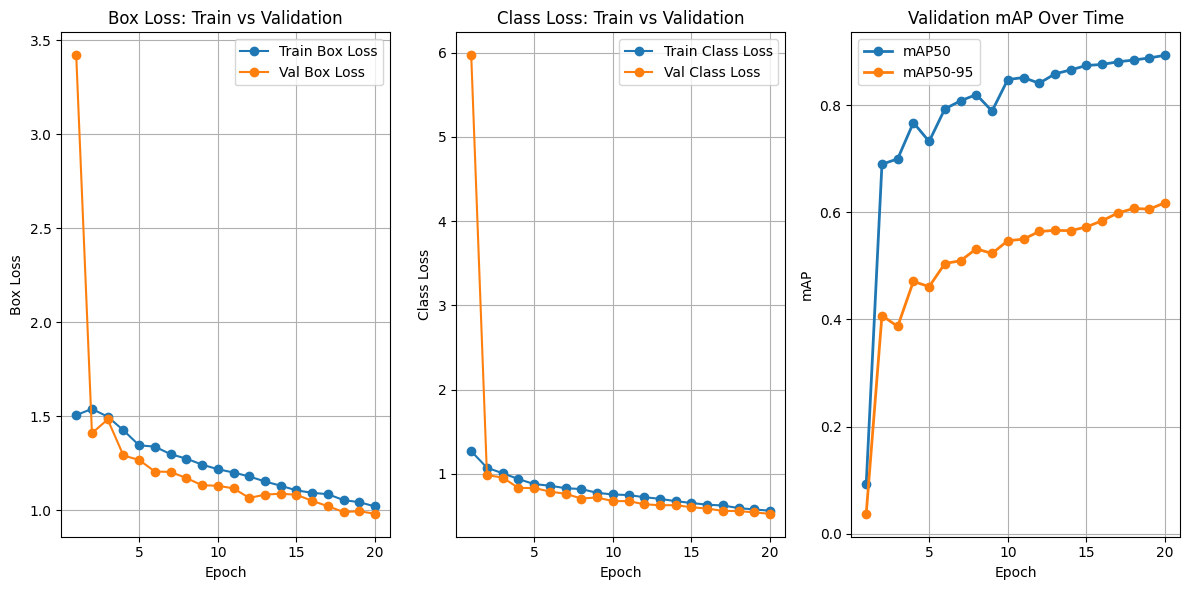

In [ ]:
# Plot training curves
plot_curve(model_v8l_results)

##### Analysis:

**Box Loss and Class Loss (Train vs Validation)**

- Both train and validation box losses drops drastically in 2nd epoch and decrease steadily and smoothly throughout training afterwards

- Validation loss is consistently lower than training loss expect 1st epoch


**Validation mAP curves**

- mAP50 shows steady improvement

- mAP50-95 shows steady improvement but with lower absolute values (as expected)

#### 2.2 Testing

In [ ]:
# Load the best YOLOv8l model after training
best_v8l_model_path="/kaggle/working/runs/detect/train2/weights/best.pt"
best_v8l_model = YOLO(best_v8l_model_path)

In [ ]:
# Evaluate on test dasetset explicitly
v8l_test_metrics = best_v8l_model.val(data="/kaggle/working/dataset/yolo/dataset.yaml", 
                                 split="test")  # split="test" tells it to use test images



Ultralytics 8.3.252 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 112 layers, 43,607,379 parameters, 0 gradients, 164.8 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1413.3±661.6 MB/s, size: 55.6 KB)
val: Scanning /kaggle/working/dataset/yolo/labels/test.cache... 672 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 672/672 256.2Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 42/42 1.3it/s 31.7s0.7ss
                   all        672       2014       0.91       0.78      0.877        0.6
Speed: 1.4ms preprocess, 42.4ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to /kaggle/working/runs/detect/val2


#### 2.3 Prediction

In [30]:
# Predict on all test images
v8l_pred_results = best_v8l_model.predict("/kaggle/working/dataset/yolo/images/test/*", conf=0.5, save=True)



image 1/672 /kaggle/working/dataset/yolo/images/test/000003_jpg.rf.d35f1b3e7a2f971d5edb6bd95bdb0af4.jpg: 640x640 1 ship, 62.6ms
image 2/672 /kaggle/working/dataset/yolo/images/test/000047_jpg.rf.a7c5a75819459815e026bd5f7c0c5d3d.jpg: 640x640 2 ships, 62.5ms
image 3/672 /kaggle/working/dataset/yolo/images/test/000059_jpg.rf.e7369a146592d0d45241a640ac951d5c.jpg: 640x640 5 ships, 56.2ms
image 4/672 /kaggle/working/dataset/yolo/images/test/000062_jpg.rf.74c3c4bcb7a59fb971a4bbe573235055.jpg: 640x640 1 ship, 38.5ms
image 5/672 /kaggle/working/dataset/yolo/images/test/000069_jpg.rf.34afecb18bccfc3ce078330ec0d18094.jpg: 640x640 (no detections), 39.0ms
image 6/672 /kaggle/working/dataset/yolo/images/test/000086_jpg.rf.bbc50f90494434e8ea43df96263ff54a.jpg: 640x640 1 ship, 39.2ms
image 7/672 /kaggle/working/dataset/yolo/images/test/000096_jpg.rf.2ceab787373bba737023b8fced5b2cb0.jpg: 640x640 1 ship, 37.9ms
image 8/672 /kaggle/working/dataset/yolo/images/test/000097_jpg.rf.7ee59769af8798229e3743973

In [31]:
# Plot the prediction results in test images
plot_pred_results(v8l_pred_results,6,3)

In [ ]:
# Zip the runs directory for download
shutil.make_archive("/kaggle/working/runs_v3_all", 'zip', "/kaggle/working/runs")

'/kaggle/working/runs_v3_all.zip'